In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from xgboost import XGBClassifier

# =========================
# 0) 데이터 로드
# =========================
df = pd.read_csv("HAM10000_metadata.csv")  # 경로 맞춰서 사용
# 여기서는 df가 이미 있다고 가정

TARGET = "dx"  # 7-class 라벨: ['akiec','bcc','bkl','df','mel','nv','vasc']

# =========================
# 1) X / y 분리
# =========================
y = df[TARGET].astype(str)
X = df.drop(columns=[TARGET])

# (강추) ID류 컬럼은 drop: 더미화하면 컬럼 폭발+학습 초느림+과적합
DROP_COLS = ["lesion_id", "image_id"]
X = X.drop(columns=DROP_COLS, errors="ignore")

# =========================
# 2) train/test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# =========================
# 3) X 전처리: object 전부 One-Hot (자동)
# =========================
# (중요) train 기준으로 object 컬럼을 잡아야 안정적
obj_cols = X_train.select_dtypes(include="object").columns.tolist()

X_train_enc = pd.get_dummies(X_train, columns=obj_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=obj_cols, drop_first=True)

# train/test 컬럼 맞추기 (필수!)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# 최종 안전 체크
left_obj = X_train_enc.select_dtypes(include="object").columns.tolist()
print("남은 object 컬럼(없어야 정상):", left_obj)
assert len(left_obj) == 0, f"아직 object 컬럼 남음: {left_obj}"

print("X_train_enc shape:", X_train_enc.shape)
print("X_test_enc  shape:", X_test_enc.shape)

# =========================
# 4) y 라벨 인코딩 (문자열 -> 0~6)
# =========================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("classes_:", le.classes_)                 # 라벨 순서 확인
print("y_train_enc unique:", np.unique(y_train_enc))

# =========================
# 5) XGBoost 다중분류 모델
# =========================
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),   # 7
    n_estimators=300,             # 먼저 200~300으로 빠르게 확인 추천
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",           # 속도 핵심
    n_jobs=-1,                    # 멀티코어
    eval_metric="mlogloss",
    random_state=42
)

# =========================
# 6) 학습 (eval_set도 인코딩된 y 넣기!)
# =========================
xgb.fit(
    X_train_enc, y_train_enc,
    eval_set=[(X_test_enc, y_test_enc)],
    verbose=50
)

# =========================
# 7) 평가
# =========================
y_pred_enc = xgb.predict(X_test_enc)
acc = accuracy_score(y_test_enc, y_pred_enc)
print("\nAccuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))

print("\nConfusion matrix:")
print(confusion_matrix(y_test_enc, y_pred_enc))

# =========================
# 8) (옵션) 예측 라벨을 원래 문자열로 복원
# =========================
y_pred_label = le.inverse_transform(y_pred_enc)
print("\n예측 라벨 예시:", y_pred_label[:10])


남은 object 컬럼(없어야 정상): []
X_train_enc shape: (8012, 20)
X_test_enc  shape: (2003, 20)
classes_: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
y_train_enc unique: [0 1 2 3 4 5 6]
[0]	validation_0-mlogloss:1.52622
[50]	validation_0-mlogloss:0.73900
[100]	validation_0-mlogloss:0.72075
[150]	validation_0-mlogloss:0.71163
[200]	validation_0-mlogloss:0.70752
[250]	validation_0-mlogloss:0.70383
[299]	validation_0-mlogloss:0.70157

Accuracy: 0.7214178731902147

Classification report:
              precision    recall  f1-score   support

       akiec       0.33      0.14      0.20        65
         bcc       0.32      0.11      0.16       103
         bkl       0.49      0.50      0.50       220
          df       0.60      0.39      0.47        23
         mel       0.33      0.23      0.27       223
          nv       0.82      0.93      0.87      1341
        vasc       0.10      0.04      0.05        28

    accuracy                           0.72      2003
   macro avg       0.43      0.33

In [ ]:
mlogloss : 정답 클래스에 높은 확률을 줬는지 보는 지표(낮을 수록 좋음)
accuracy : 2003개 중에 약 83.5%를 맞춤(nv를 얼마나 잘 맞히는지에 따라 크게 끌려간다.)
nv : 
mell recall : 과진단 존재
akiec, bcc, vasc : 거의 다 mell로 흡수됨
macro avg : 각 클래스를 똑같이 1표로 평균냄 > 소수 클래스 성능이 낮으면 macro가 확 내려감
weighted avg : 표본 수로 가중치를 줌
>> 전체적으로 잘 맞히는 것 같지만, 소수 클래스는 약하다

행 : 실제 라벨
열 : 예측 라벨
악성: mel, bcc, akiec
양성: nv, bkl, df, vasc



In [3]:
from sklearn.metrics import average_precision_score, roc_auc_score

malignant = {"mel", "bcc", "akiec"}  # 필요하면 조정 가능

y_test_bin = y_test.astype(str).isin(malignant).astype(int)
# 다중분류 확률 (N,7)
y_proba_multi = xgb.predict_proba(X_test_enc)

# 악성 클래스 인덱스 찾기
mal_idx = [np.where(le.classes_ == c)[0][0] for c in malignant if c in le.classes_]
print("malignant class idx:", mal_idx, "->", le.classes_[mal_idx])

# 악성 확률 = 악성 클래스 확률의 합(OVR처럼)
y_proba_bin = y_proba_multi[:, mal_idx].sum(axis=1)

# PR-AUC / ROC-AUC
pr_auc = average_precision_score(y_test_bin, y_proba_bin)
roc_auc = roc_auc_score(y_test_bin, y_proba_bin)

print("Binary PR-AUC (malignant vs benign):", pr_auc)
print("Binary ROC-AUC:", roc_auc)


malignant class idx: [1, 4, 0] -> ['bcc' 'mel' 'akiec']
Binary PR-AUC (malignant vs benign): 0.5653398302330785
Binary ROC-AUC: 0.8810091195826697


Binary PR-AUC (malignant vs benign): 0.5653398302330785
>> 실전성능
>> 악성 놓치지 않는지, 불균형 데이터, threshold와 관련
Binary ROC-AUC: 0.8810091195826697
>> 전체적으로 잘 구분하는 정도

X_train_enc: (8012, 20)
X_test_enc : (2003, 20)
pos=1563, neg=6449, scale_pos_weight=4.13
[0]	train-aucpr:0.54881	valid-aucpr:0.52963
[50]	train-aucpr:0.56750	valid-aucpr:0.54087
[100]	train-aucpr:0.57515	valid-aucpr:0.54002
[150]	train-aucpr:0.57993	valid-aucpr:0.54428
[193]	train-aucpr:0.58277	valid-aucpr:0.54444

Binary ROC-AUC: 0.8803998781517138
Binary PR-AUC : 0.5442345176658937

--- Threshold sweep ---
t=0.15 | FP= 627 FN=   1 | recall=0.997 precision=0.383
t=0.20 | FP= 613 FN=   1 | recall=0.997 precision=0.389
t=0.25 | FP= 606 FN=   1 | recall=0.997 precision=0.392
t=0.30 | FP= 590 FN=   2 | recall=0.995 precision=0.397
t=0.35 | FP= 564 FN=   3 | recall=0.992 precision=0.408
t=0.40 | FP= 525 FN=   7 | recall=0.982 precision=0.422

=== Report @ threshold = 0.25 ===
              precision    recall  f1-score   support

      benign       1.00      0.62      0.77      1612
   malignant       0.39      1.00      0.56       391

    accuracy                           0.70      200

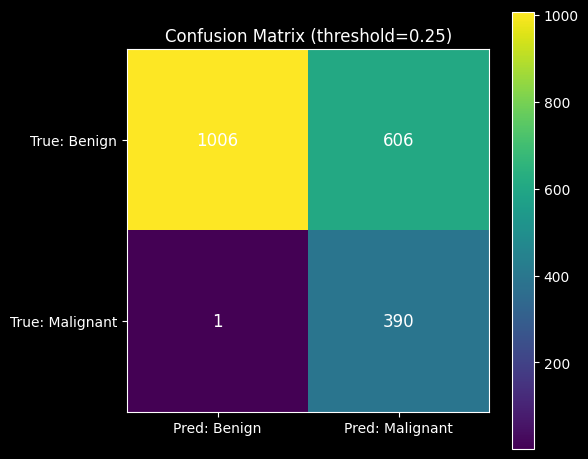

In [10]:
# =====================================
# 0. 라이브러리
# =====================================
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# =====================================
# 1. 데이터 로드 (RAW 유지)
# =====================================
df = pd.read_csv("HAM10000_metadata.csv")

TARGET = "dx"
DROP_COLS = ["lesion_id", "image_id"]

# 악성 정의 (의료적으로 가장 흔한 기준)
MALIGNANT = {"mel", "bcc", "akiec"}

# =====================================
# 2. X / y 구성 (이진 라벨)
# =====================================
y_str = df[TARGET].astype(str)
y = y_str.isin(MALIGNANT).astype(int)   # 악성=1, 양성=0

X = df.drop(columns=[TARGET])
X = X.drop(columns=DROP_COLS, errors="ignore")

# =====================================
# 3. Train / Test split (stratify 필수)
# =====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# =====================================
# 4. One-Hot Encoding (object 자동 처리)
# =====================================
obj_cols = X_train.select_dtypes(include="object").columns.tolist()

X_train_enc = pd.get_dummies(X_train, columns=obj_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=obj_cols, drop_first=True)

# 컬럼 정렬 맞추기
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# 안전 체크
assert X_train_enc.select_dtypes(include="object").empty
print("X_train_enc:", X_train_enc.shape)
print("X_test_enc :", X_test_enc.shape)

# =====================================
# 5. DMatrix 생성
# =====================================
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dvalid = xgb.DMatrix(X_test_enc,  label=y_test)

# 불균형 보정
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print(f"pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

# =====================================
# 6. XGBoost 파라미터
# =====================================
params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",     # 불균형 데이터 핵심
    "max_depth": 4,
    "eta": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "tree_method": "hist",
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
    "nthread": -1
}

# =====================================
# 7. 학습 (Early Stopping 확실)
# =====================================
evals = [(dtrain, "train"), (dvalid, "valid")]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=3000,       # 크게 주고
    evals=evals,
    early_stopping_rounds=50,   # 여기서 자동 중단
    verbose_eval=50
)

# =====================================
# 8. 예측 + AUC / PR-AUC
# =====================================
y_proba = bst.predict(dvalid)   # binary → 확률 바로 나옴

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)

print("\nBinary ROC-AUC:", roc_auc)
print("Binary PR-AUC :", pr_auc)

# =====================================
# 9. Threshold 평가 (FP / FN trade-off)
# =====================================
def eval_threshold(t):
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn) if (tp + fn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    print(f"t={t:.2f} | FP={fp:4d} FN={fn:4d} | recall={recall:.3f} precision={precision:.3f}")

print("\n--- Threshold sweep ---")
for t in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]:
    eval_threshold(t)

# =====================================
# 10. 최종 리포트 (예시 threshold)
# =====================================
BEST_T = 0.25
y_pred = (y_proba >= BEST_T).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(f"\n=== Report @ threshold = {BEST_T} ===")
print(classification_report(y_test, y_pred, target_names=["benign", "malignant"]))
print("confusion matrix:\n", confusion_matrix(y_test, y_pred))

# =========================
# 시각화
# =========================
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

# 축 라벨
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred: Benign", "Pred: Malignant"])
ax.set_yticklabels(["True: Benign", "True: Malignant"])

# 제목
ax.set_title(f"Confusion Matrix (threshold={BEST_T})")

# 숫자 표시
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

# 컬러바
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
